# FreqTrade backtesting analysis and plotting notebook

Version: v1.1

Date: 2023-07-08

GitHub: https://github.com/froggleston/freqtrade_analysis_notebook

Authors:
* **@froggleston** (for the notebook and some of the notebook_helper code)
* **@rk** (for most of the notebook_helper code)

### Welcome to the Notebook

This notebook should make it easier to run sequential test backtests and compare them against a single benchmark backtest.

### Plotting Frameworks

Since v1.1, this notebook supports plotting using bokeh as well as plotly. bokeh has some major benefits in that many of
the glyphs are rendered using webgl, improving speed greatly. However, the library is immature and more prone to change
than plotly.

To use bokeh, you don't need to change anything.

To use plotly, in the final plotting cell, change the line to read `plotter = PlotHelper(plotlib="plotly").plotter`

### Things to Note

* If parallel is set to True, it runs a per month backtest per core unlike the usual freqtrade backtests.
* This will use more memory, like hyperopting, so backtests can be killed if you use too many cores and run out of memory
* If parallel, backtests will "reset" each month so unlimited stake backtests will only give you cumulative results per month.

## Load prerequisites

**Only needs to be run once**

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import joblib, json, os, random, sys, time, traceback
from time import perf_counter
from collections import deque
from datetime import datetime, timedelta
from pathlib import Path

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

from freqtrade.enums import RunMode, CandleType
from freqtrade.misc import deep_merge_dicts
from freqtrade.configuration import Configuration, TimeRange
from freqtrade.data.btanalysis import load_trades_from_db, load_backtest_data, load_backtest_stats
from freqtrade.data.history import load_pair_history
from freqtrade.data.dataprovider import DataProvider
import freqtrade.data.entryexitanalysis as eea
from freqtrade.plugins.pairlistmanager import PairListManager
from freqtrade.exceptions import ExchangeError, OperationalException
from freqtrade.exchange import Exchange
from freqtrade.resolvers import ExchangeResolver, StrategyResolver

import notebook_helper
notebook_helper.setup()

from plot_helper import PlotHelper

import nest_asyncio
nest_asyncio.apply()

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

Notebook setup done


## Configuration

In [13]:
## main configuration for everything ##

# main freqtrade dir
# use '.' if you copy the notebook files into your ft dir
freqtrade_dir = "."

if 'executed' not in globals():
    executed = True         # Guard against running this multiple times
    cwd = os.getcwd()       # equivalent to !pwd
    # cwd = cwd[0]          # only use if using !pwd above
    sys.path.append(cwd)    # Add notebook dir to python path for utility imports
    # cd to root directory to make relative paths in config valid
    %cd freqtrade_dir

# parallelise backtests by month
parallel = True
proportion_cores_parallel = 0.33 # set to a third of available cores, e.g. 12 cores, will use 4

# set to true if you want to open all slots to test buys without rejections
reject_test = False
if reject_test:
    max_open_trades = -1
    dry_run_wallet = 6900 # nice
else:
    max_open_trades = 5
    dry_run_wallet = 2000

stake_amount = dry_run_wallet / max_open_trades
if stake_amount < 100:
    stake_amount = 100

# shorting or not
short = False

# exchange
exchange = "binance"

# # set benchmark and test strategies to compare
bench_strat = "name_of_your_benchmark_strat"
test_strat = "name_of_your_test_strat"

# # set your config file
config_file = f"{freqtrade_dir}/your_config.json"

# set your format and path to downloaded data
data_format = "json"
data_location = Path('/path', 'to', 'your', 'data', f'{exchange}')

# set your stake currency and stake format
stake_currency = "USDT"
    
# set your chosen stoploss
stoploss = -0.125

# set your minimal roi
# this can be an empty dict if using a newer FT version
minimal_roi = { '0': 10 }

# turn off/on protections
enable_protections = True

ft_config = Configuration.from_files(files=[config_file])
pairlist = ft_config['exchange'].get('pair_whitelist', None)
pair_count = len(pairlist)

timeframe_detail = None

# uncomment both lines for 1m detail
# timeframe_detail = "1m"
# ft_config['timeframe_detail'] = timeframe_detail

ft_config['datadir'] = data_location

if short:
    trading_mode = CandleType.FUTURES
    stake = f"{stake_currency}:{stake_currency}"
    
    config = {
        'max_open_trades': max_open_trades,
        'dry_run_wallet': dry_run_wallet,
        'stake_amount': stake_amount,
        'stake_currency': stake_currency,
        'exchange': {
            'name': exchange,
        },
        'export': 'signals',
        'datadir': str(data_location),
        'trading_mode': 'futures',
        'margin_mode': 'isolated',
        'dataformat_ohlcv':data_format,
        'stoploss': ft_config.get("stoploss", stoploss),
        'minimal_roi': minimal_roi,
    }
else:
    trading_mode = CandleType.SPOT
    stake = f"{stake_currency}"
    
    config = {
        'max_open_trades': max_open_trades,
        'dry_run_wallet': dry_run_wallet,
        'stake_amount': stake_amount,
        'stake_currency': stake_currency,
        'exchange': {
            'name': exchange,
        },
        'stoploss': ft_config.get("stoploss", stoploss),
        'export': 'signals',
        'datadir': str(data_location),
        'dataformat_ohlcv':data_format,
        'minimal_roi': minimal_roi,
        'enable_protections': enable_protections,
    }

bench_config = {
    'strategy': bench_strat,
    'pair_count': [pair_count],
    'config': [
        config_file,
        deep_merge_dicts({
        }, config)
    ]
}

strat_config = {
    'strategy': test_strat,
    'pair_count': [pair_count],
    'config': [
        config_file,
        deep_merge_dicts({
        }, config)
    ]
}    

## Run Benchmark Strategy

In [6]:
## set overall full timerange to use for benchmark and test backtests
timerange = "20230601-20230625"

## shouldn't need to change anything below here

# prepare configs and timeranges
test_timeranges = list(notebook_helper.split_timerange(timerange))
both_configs = [bench_config,strat_config]
for c in both_configs:
    c['timeranges'] = test_timeranges

# file to cache benchmark results
# so we can run multiple test strat runs without having to redo this
bench_pklf = f"{freqtrade_dir}/user_data/backtest_results/{bench_config['strategy']}-results_{timerange}-{max_open_trades}_{dry_run_wallet}_{int(stake_amount)}.pkl"

if not os.path.exists(bench_pklf):
    print("Creating", bench_pklf)
    print(bench_config, data_location, data_format, trading_mode)

    # do backtesting per month
    try:
        start_time = perf_counter()
        results = notebook_helper.backtest_all([bench_config], parallel, proportion_cores_parallel, data_location=data_location, data_format=data_format, trading_mode=trading_mode, timeframe_detail=timeframe_detail)
        end_time = perf_counter()

        pkl_results = []

        for rrs in results:
            for rrss in rrs[1]:
                if bench_config['strategy'] == rrss["key"]:
                    pkl_results.append(rrs)

        file = open(bench_pklf, "wb")
        joblib.dump(pkl_results, file)
        file.close()

        print(f"Done creating benchmark backtest. Elapsed time: {(end_time - start_time)/60}")
    except Exception as e:
        print(e)
else:
    print(f"Loaded previous backtest result from: {bench_pklf}")

Loaded previous backtest result from: /home/froggleston/git/freqtrade/user_data/backtest_results/high_frog_binance_v216-results_20230601-20230625-5_2000_400.pkl


## Run Test Strategy

**Only run a backtest for the test strat, not the benchmark. Once a benchmark backtest is complete, this can be run multiple times.**

As long as the single_tr is a smaller timerange than the benchmark strategy timerange, this can speed up comparison a lot.

This will use the previously cached bechmark backtest result from the pkl file

Running backtest for high_frog_binance_v219_dca


  0%|          | 0/1 [00:00<?, ?it/s]

Result for strategy high_frog_binance_v219_dca
============================================================= BACKTESTING REPORT ============================================================
|       Pair |   Entries |   Avg Profit % |   Cum Profit % |   Tot Profit USDT |   Tot Profit % |    Avg Duration |   Win  Draw  Loss  Win% |
|------------+-----------+----------------+----------------+-------------------+----------------+-----------------+-------------------------|
|  AVAX/USDT |         1 |           8.43 |           8.43 |            33.744 |           1.69 |         0:05:00 |     1     0     0   100 |
|   FLM/USDT |         2 |           3.21 |           6.41 |            25.679 |           1.28 |         4:22:00 |     2     0     0   100 |
|   WRX/USDT |         2 |           2.48 |           4.97 |            23.563 |           1.18 |         5:00:00 |     2     0     0   100 |
| ALICE/USDT |         2 |           2.82 |           5.63 |            22.554 |           1.13 |    

|      TOTAL |        66 |           0.75 |          49.54 |           202.034 |          10.10 |         9:43:00 |    56     0    10  84.8 |
========================================================= LEFT OPEN TRADES REPORT ==========================================================
|       Pair |   Entries |   Avg Profit % |   Cum Profit % |   Tot Profit USDT |   Tot Profit % |   Avg Duration |   Win  Draw  Loss  Win% |
|------------+-----------+----------------+----------------+-------------------+----------------+----------------+-------------------------|
| MATIC/USDT |         1 |          -1.21 |          -1.21 |            -4.851 |          -0.24 |        8:25:00 |     0     0     1     0 |
|      TOTAL |         1 |          -1.21 |          -1.21 |            -4.851 |          -0.24 |        8:25:00 |     0     0     1     0 |
====================================================================== ENTER TAG STATS ==================================================================

| Market change               | -8.12%              |

Backtested 2023-06-01 00:00:00 -> 2023-06-25 00:00:00 | Max open trades : 5
================================================================================ STRATEGY SUMMARY ===============================================================================
|                   Strategy |   Entries |   Avg Profit % |   Cum Profit % |   Tot Profit USDT |   Tot Profit % |   Avg Duration |   Win  Draw  Loss  Win% |           Drawdown |
|----------------------------+-----------+----------------+----------------+-------------------+----------------+----------------+-------------------------+--------------------|
| high_frog_binance_v219_dca |        66 |           0.75 |          49.54 |           202.034 |          10.10 |        9:43:00 |    56     0    10  84.8 | 52.459 USDT  2.33% |

For more details, please look at the detail tables above
Elapsed time: 6.880271397716691
+------------+----------------------------------------+------------

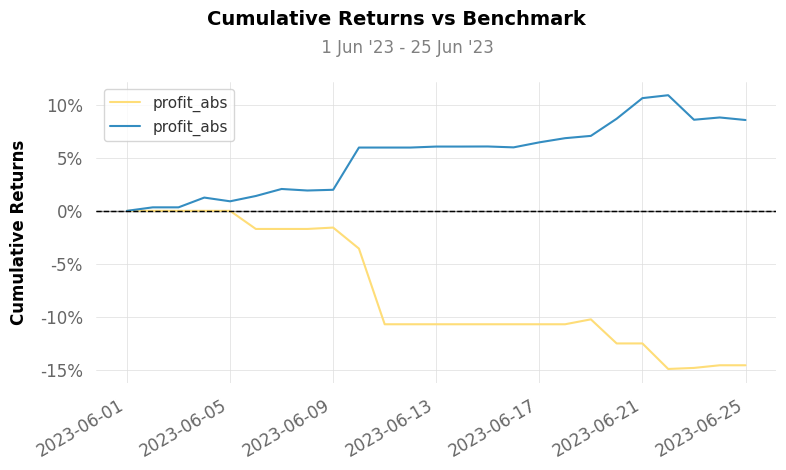

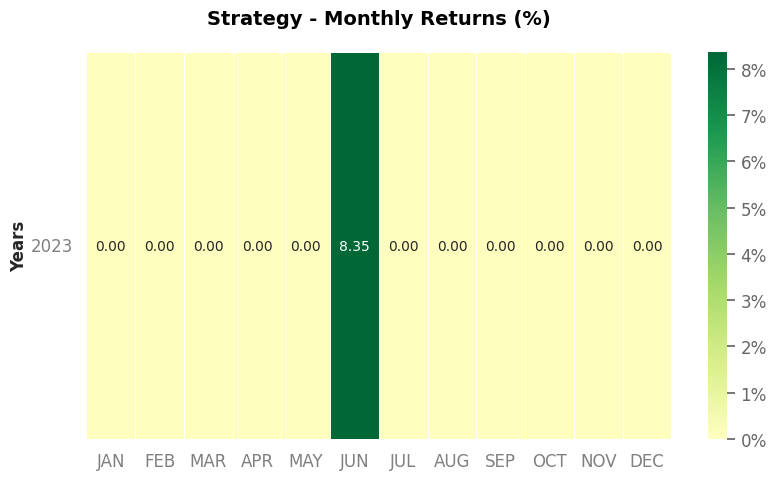

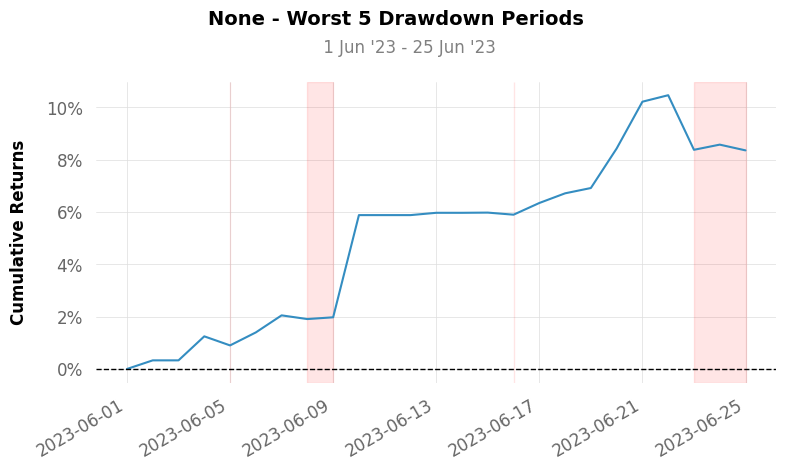

In [14]:
# run the test strategy for the same timerange as benchmark 
single_tr = timerange

# uncomment to specify a timerange that is the same as or smaller than the original timerange
# single_tr = "20220901-20221201"

# pickle test strat backtest. useful if backtesting a large timerange you want to come back to
single_pickle = False

if os.path.exists(bench_pklf):
    redo_results = []
    
    dtformat = "%Y%m%d"
    basedate = single_tr.split("-")[0]
    basedate_rounded = pd.Series(basedate).astype('datetime64[ns, UTC]')
    basedate_rounded = (basedate_rounded - pd.tseries.offsets.MonthBegin(1)).iloc[0].strftime(dtformat)
    
    load_results = []
    with (open(bench_pklf, "rb")) as openfile:
        while True:
            try:
                load_results.append(joblib.load(openfile))
            except EOFError:
                break
                
    single_config = [strat_config.copy()]
    redo_config = [bench_config.copy(), strat_config.copy()]
    single_trs = list(notebook_helper.split_timerange(single_tr))
    
    single_config[0]["timeranges"] = single_trs
    redo_config[0]["timeranges"] = single_trs
    redo_config[1]["timeranges"] = single_trs
    
    single_pklf = f"{freqtrade_dir}/user_data/backtest_results/{strat_config['strategy']}-results_{single_tr}-{max_open_trades}_{dry_run_wallet}_{int(stake_amount)}.pkl"
    if single_pickle:
        if not os.path.exists(single_pklf):
            print(f"Running backtest for {test_strat}")
            start_time = perf_counter()
            single_results = notebook_helper.backtest_all(single_config, parallel, proportion_cores_parallel, data_location=data_location, data_format=data_format, trading_mode=trading_mode, timeframe_detail=timeframe_detail)
            end_time = perf_counter()
            print(f"Elapsed time: {(end_time - start_time)/60}")
            
            single_pkl_results = []

            for rrs in single_results:
                for rrss in rrs[1]:
                    if strat_config['strategy'] == rrss["key"]:
                        single_pkl_results.append(rrs)

            sfile = open(single_pklf, "wb")
            joblib.dump(single_pkl_results, sfile)
            sfile.close()
        else:
            print(f"Loading backtest for {test_strat}")
            single_results = []
            with (open(single_pklf, "rb")) as openfile:
                while True:
                    try:
                        single_results.append(joblib.load(openfile))
                    except EOFError:
                        break
            single_results = single_results[0]
    else:
        print(f"Running backtest for {test_strat}")
        start_time = perf_counter()
        single_results = notebook_helper.backtest_all(single_config, parallel, proportion_cores_parallel, data_location=data_location, data_format=data_format, trading_mode=trading_mode, timeframe_detail=timeframe_detail)
        end_time = perf_counter()
        print(f"Elapsed time: {(end_time - start_time)/60}")        
    
    redo_dict = {}
    redo_trs = [x.split("-")[0] for x in single_trs]
    
    ## add results:
    ## - if the original monthly dates start on the first day of the month and match the redo dates
    ## - if the original monthly dates do not start on the first day of the month and neither do the redo dates
    rounded_redo_trs = []
    for i in redo_trs:
        tm_rounded = pd.Series(i).astype('datetime64[ns, UTC]')
        
        if tm_rounded.iloc[0].day != 1:
            tm_rounded = (tm_rounded - pd.tseries.offsets.MonthBegin(1)).iloc[0].strftime(dtformat)
        else:
            tm_rounded = tm_rounded.iloc[0].strftime(dtformat)
        
        rounded_redo_trs.append(tm_rounded)
    
    for lrs in load_results[0]:
        resdate = lrs[1][0]["date"].replace("-","")
        
        if resdate in rounded_redo_trs:
            redo_dict[resdate] = lrs
        elif resdate in redo_trs:
            tm_rounded = pd.Series(i).astype('datetime64[ns, UTC]')
            if tm_rounded.iloc[0].day != 1:
                tm_rounded = (tm_rounded - pd.tseries.offsets.MonthBegin(1)).iloc[0].strftime(dtformat)
            else:
                tm_rounded = tm_rounded.iloc[0].strftime(dtformat)
            redo_dict[tm_rounded] = lrs
    
    for srs in single_results:
        srsdate = srs[1][0]["date"].replace("-","")
        
        tm_rounded = pd.Series(srsdate).astype('datetime64[ns, UTC]')
        
        if tm_rounded.iloc[0].day != 1:
            tm_rounded = (tm_rounded - pd.tseries.offsets.MonthBegin(1)).iloc[0].strftime(dtformat)
        else:
            tm_rounded = tm_rounded.iloc[0].strftime(dtformat)
        
        redo_results.append(redo_dict[tm_rounded])
        
        # reset config_i
        new_srs_tuple = (srs[0], srs[1], srs[2], srs[3], 1, srs[5])
        redo_results.append(new_srs_tuple)
    
    load_strategy_comparison, load_strategy_trades, load_strategy_signal_candles = notebook_helper.prepare_results(redo_config, redo_results)
    notebook_helper.print_quant_stats(redo_config, load_strategy_comparison, load_strategy_trades, table=True, output=f"{freqtrade_dir}/user_data/notebooks/"+"{strategy}-vs-{benchmark}.html")

    br_comparison = load_strategy_comparison
    br_trades = load_strategy_trades
    br_candles = load_strategy_signal_candles

## Prepare Test Strategy Backtesting Results

**This section needs to be run after each test strategy backtest for comparison, analysis and plotting** 

In [15]:
# do backtesting-analysis output
from tabulate import tabulate

import nest_asyncio
nest_asyncio.apply()

stratnames = []
for tcs in both_configs:
    stratnames += [tcs['strategy']]

stratnames += [single_config[0]['strategy']]

atd_results={}
trade_dict={}

all_results = []
atd={}

for strat in stratnames:
    atd[strat] = {}
    trade_dict[strat] = pd.DataFrame()

for stratname in stratnames:
    ft_config['strategy'] = stratname
    
    if stratname in br_candles:
        stratdf = br_candles[stratname]

        for sts in br_trades:
            if br_trades[sts].strategy_name == stratname:
                trades = br_trades[sts].trades
                trade_dict[stratname] = trades

        strat_results = []

        current_count = 1
        for pair in pairlist:
            if pair in stratdf and len(stratdf[pair]) > 0:
                trades_red = eea._analyze_candles_and_indicators(pair, trades, stratdf[pair])
                atd[stratname][pair] = trades_red
                strat_results.append((pair,atd))
                current_count += 1
        
        print(f"Adding {stratname} to comparison")
        atd_results[stratname] = strat_results
    else:
        print(f"Ignoring '{stratname}' in previous output.")


Adding high_frog_binance_v216 to comparison
Adding high_frog_binance_v219_dca to comparison
Adding high_frog_binance_v219_dca to comparison


## Run Dry/Live vs Backtest Comparison

**This requires a dry run / live sqlite database to be available on the db_name path specified**

Can be skipped if you don't want to compare dry/live to backtest

In [ ]:
import sqlite3
from freqtrade.data.btanalysis import load_backtest_data, load_backtest_stats

# specify your actual trades from a dry/live DB
db_path = "your_db_name.sqlite"

# if backtest_dir points to a directory, it'll automatically load the last backtest file
backtest_dir = "user_data/backtest_results"

# or specify a specific backtest results file
# backtest_dir = config["user_data_dir"] / "backtest_results/backtest-result-2020-07-01_20-04-22.json"

dat = sqlite3.connect(db_path)
sel_cols = "pair,open_date,close_date,min_rate,max_rate,enter_tag,exit_reason,open_rate,close_rate,close_profit,close_profit_abs"
query = dat.execute(f"SELECT {sel_cols} FROM trades")
cols = [column[0] for column in query.description]
sql_trades = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

sql_trades['real_open_date'] = sql_trades['open_date'].astype('datetime64[ns, UTC]')
sql_trades['open_date'] = sql_trades['real_open_date'].dt.floor('T')
sql_trades['close_date'] = sql_trades['close_date'].astype('datetime64[ns, UTC]')

analyse_strat = stratnames[0]

# bt_trades = load_backtest_data(backtest_dir)
bt_trades = trade_dict[analyse_strat].copy() #.sort_values(by='open_date')
bt_trades.reset_index(drop=True, inplace=True)

# bt_signals = atd_results[analyse_strat]
bt_signals = atd[analyse_strat]

if "orders" in bt_trades:
    bt_trades.drop('orders', axis=1, inplace=True)    

num_real_trades = sql_trades.shape[0]
num_bt_trades = bt_trades.shape[0]

if (num_real_trades > 0):
    print(analyse_strat)
## round down open_date to nearest minute
compare_start_date = sql_trades.iloc[0]['open_date'].floor('T')
compare_end_date = sql_trades.iloc[len(sql_trades)-1]['open_date'].floor('T')
bt_end_date = bt_trades.iloc[len(bt_trades)-1]['open_date'].floor('T')

bt_trades.rename(columns = {'profit_ratio':'close_profit','profit_abs':'close_profit_abs'}, inplace = True)

bt_trades = bt_trades.loc[(bt_trades['open_date'] >= compare_start_date) & (bt_trades['open_date'] <= compare_end_date)]
sql_trades = sql_trades.loc[(sql_trades['open_date'] <= bt_end_date)]

print("REAL\n", tabulate(sql_trades, headers='keys', tablefmt='psql', showindex=True))
print("BT\n", tabulate(bt_trades[sel_cols.split(",")], headers='keys', tablefmt='psql', showindex=True))

merged_df = pd.merge(sql_trades, bt_trades, how ='outer', on =['pair', 'open_date'], suffixes=('_sql', '_bt')).sort_values(by='open_date')

# rebuild df from all signal pairs
alldf = pd.DataFrame()
for pair, sig_df in bt_signals.items(): # pairs
    dropped_sig_df = sig_df.reset_index(drop=True, inplace=False)
    dropped_sig_df = dropped_sig_df.loc[(dropped_sig_df['open_date'] >= compare_start_date) & (dropped_sig_df['open_date'] <= compare_end_date) & (dropped_sig_df['open_date'] <= bt_end_date)]            
    alldf = pd.concat([alldf, dropped_sig_df])
    
num_all_trades = merged_df.shape[0]

merged_df['time_pair_match'] = np.where(
    (merged_df["close_profit_bt"].isnull() | merged_df["close_profit_sql"].isnull()),
    False,
    True
)

merged_df.loc[(merged_df['time_pair_match'] == True) & merged_df["enter_tag_sql"].notna() & merged_df["enter_tag_bt"].notna(), ['side']] = "<>"
merged_df.loc[(merged_df['time_pair_match'] == False) & merged_df["enter_tag_sql"].isna() & merged_df["enter_tag_bt"].notna(), ['side']] = "B<"
merged_df.loc[(merged_df['time_pair_match'] == False) & merged_df["enter_tag_sql"].notna() & merged_df["enter_tag_bt"].isna(), ['side']] = ">R"

both_df = merged_df.loc[(merged_df['side'] == "<>")]
bt_only = merged_df.loc[(merged_df['side'] == "B<")]
sql_only = merged_df.loc[(merged_df['side'] == ">R")]

num_match = both_df.shape[0]
num_sql_only = sql_only.shape[0]
num_bt_only = bt_only.shape[0]

sum_profit_match_sql = round(both_df['close_profit_abs_sql'].sum(), 2)
sum_profit_pct_match_sql = round(both_df['close_profit_sql'].sum(), 2)

sum_profit_match_bt = round(both_df['close_profit_abs_bt'].sum(), 2)
sum_profit_pct_match_bt = round(both_df['close_profit_bt'].sum(), 2)

sum_profit_sql_only = round(sql_only['close_profit_abs_sql'].sum(), 2)
sum_profit_pct_sql_only = round(sql_only['close_profit_sql'].sum(), 2)

sum_profit_bt_only = round(bt_only['close_profit_abs_bt'].sum(), 2)
sum_profit_pct_bt_only = round(bt_only['close_profit_bt'].sum(), 2)

merged_df['entry_match'] = np.where(
    (merged_df["enter_tag_sql"] == merged_df["enter_tag_bt"]),
    True,
    False
)

merged_df['exit_match'] = np.where(
    (merged_df["exit_reason_sql"] == merged_df["exit_reason_bt"]),
    True,
    False
)

merged_df['good_entry_price'] = np.where(
    (merged_df["open_rate_sql"] <= merged_df["open_rate_bt"]),
    True,
    False
)
    
merged_df['no_entry_lag'] = np.where(
    ((merged_df["real_open_date"] - merged_df["open_date"]) < timedelta(seconds=60)),
    True,
    False
)

merged_df['close_profit_pct_diff'] = round(abs(merged_df['close_profit_sql'] - merged_df['close_profit_bt'])*100, 5)
merged_df['close_rate_pct_diff'] = round((merged_df['close_rate_sql'] - merged_df['close_rate_bt'])/merged_df['open_rate_sql']*100, 5)
merged_df['open_rate_pct_diff'] = round((merged_df['open_rate_sql'] - merged_df['open_rate_bt'])/merged_df['open_rate_sql']*100, 5)        

print(merged_df[['pair','open_date','side','time_pair_match','entry_match','exit_match','no_entry_lag','good_entry_price','open_rate_pct_diff','close_rate_pct_diff']])

# ------------

print("")
print(f"Avg difference in closed profit : {round(merged_df['close_profit_pct_diff'].mean(), 2)}% ")
print(f"Absolute profit (real vs bt)    : {round(merged_df['close_profit_abs_sql'].sum(), 2)} vs {round(merged_df['close_profit_abs_bt'].sum(), 2)}")
print(f"Pct profit (real vs bt)         : {round(merged_df['close_profit_sql'].sum(), 2)} vs {round(merged_df['close_profit_bt'].sum(), 2)}")
print("")

print(f"Match count                     : {num_match} / {num_all_trades}")
print(f"Match profit pct (real vs bt)   : {sum_profit_pct_match_sql} vs {sum_profit_pct_match_bt}")
print(f"Match abs profit (real vs bt)   : {sum_profit_match_sql} vs {sum_profit_match_bt}")
print("")

print(f"Num real only                   : {num_sql_only} / {num_all_trades}")
print(f"Abs Profit real only            : {sum_profit_sql_only}")
print(f"Pct Profit real only            : {sum_profit_pct_sql_only}")
print("")

print(f"Num backtest only               : {num_bt_only} / {num_all_trades}")
print(f"Abs Profit backtest only        : {sum_profit_bt_only}")
print(f"Pct Profit backtest only        : {sum_profit_pct_bt_only}")
print("")

num_perfect_matches = merged_df.loc[(merged_df['time_pair_match'] & merged_df['entry_match'] & merged_df['exit_match'] & merged_df['no_entry_lag'] & merged_df['good_entry_price'])].shape[0]
print(f"Perfect trades                  : {round(100 - (((num_all_trades-num_perfect_matches)/num_all_trades) * 100), 2)}%")

num_very_good_matches = merged_df.loc[(merged_df['time_pair_match'] & merged_df['entry_match'] & merged_df['no_entry_lag'] & merged_df['good_entry_price'])].shape[0]
print(f"Very good trades and above      : {round(100 - (((num_all_trades-num_very_good_matches)/num_all_trades) * 100), 2)}%")

num_good_matches = merged_df.loc[(merged_df['time_pair_match'] & merged_df['no_entry_lag'] & (merged_df['good_entry_price'] | (merged_df['open_rate_pct_diff'] < 0.1)))].shape[0]
print(f"Good trades and above           : {round(100 - (((num_all_trades-num_good_matches)/num_all_trades) * 100), 2)}%")

## Run Backtesting Analysis

In [16]:
enter_tags="all"
# enter_tags="your_buy_tag"

exit_tags="all"
# exit_tags="trailing_stop_loss,stop_loss"
# exit_tags="your_sell_tag_a,your_sell_tag_b"

il="open_date,close_date,close,high,low,profit_abs,profit_ratio"

sr = list(atd_results.keys())[1]
print(sr)
prepped_results = eea.prepare_results(atd, sr, enter_tags.split(","), exit_tags.split(","), timerange=TimeRange.parse_timerange(single_tr))
eea.print_results(prepped_results, ["0","1","2","5"], il.split(","), csv_path=".", to_csv=False)

high_frog_binance_v219_dca
Group 0:
+-----------------------------+------------------+--------+----------+-------------------+-------------------+--------------+----------------+-----------+------------+
| enter_reason                |   total_num_buys |   wins |   losses |   profit_abs_wins |   profit_abs_loss |   profit_tot |   wl_ratio_pct |   avg_win |   avg_loss |
|-----------------------------+------------------+--------+----------+-------------------+-------------------+--------------+----------------+-----------+------------|
| clork_sm_ha_cross           |                1 |      1 |        0 |          1.95556  |           0       |     1.95556  |       100      |  1.95556  |    0       |
| clork_bb_diff_hl3rsi_b      |                1 |      1 |        0 |          2.30771  |           0       |     2.30771  |       100      |  2.30771  |    0       |
| clork_newboi_a              |                1 |      0 |        1 |          0        |         -18.0769  |   -18.0769   

## Run Plotting

**Set a small plot_tr timerange if your benchmark timerange was large**

Usually 2-3 months maximum per pair is OK, anything longer or with more pairs gets slooooow.

In [17]:
# construct the plotting framework
# DEFAULTS TO bokeh + webgl
# to revert back to plotly plots use `plotter = PlotHelper(plotlib="plotly").plotter`
plotter = PlotHelper().plotter

# plot the same timerange as the current test strategy
plot_tr = single_tr

# uncomment to specify a timerange that is the same as or smaller than the benchmark or test timerange
# plot_tr = "20210301-20210401"

# uncomment to set timerange to None for full benchmark strategy candle timerange - not recommended
# plot_tr = None

# set the pairs you want to plot
# for longer timeranges, consider only plotting one pair at a time
pairs_to_plot = ["KSM"]

## do not edit. used for plotting.
if plot_tr is not None:
    dfs = plot_tr.split("-")[0]
    dfe = plot_tr.split("-")[1]
else:
    dfs = single_tr.split("-")[0]
    dfe = single_tr.split("-")[1]

# set plot output dimensions
width=2120
height=900

plot_config = {
    'main_plot': {
        'ema_8': {'color': 'gold'},
        'ema_20': {'color': 'darkgoldenrod'},
        #'ema_34': {'color': 'rgba(0, 255, 0, 0.8)'},
        #'ema_50': {'color': 'rgba(0, 255, 0, 1)'},
        
        # uncomment if using bokeh and want to plot markers on candles
        # the indicators used here must be set to 1 in the main freqtrade dataframe
        # marker list is: https://docs.bokeh.org/en/2.4.2/docs/reference/models/markers.html#scatter
        
        # 'indicator_a': {'marker':'star', 'color':'orange'},
        # 'indicator_b': {'marker':'hex', 'color':'black'},
        # 'indicator_c': {'marker':'square_pin', 'color':'fuchsia'},
        
        # uncomment if using bokeh and want to plot annotation spans across candles
        # the indicators used here must be set to 1 in the main freqtrade dataframe
        # 'indicator_d': {'box': 'orange'},
    },
    'subplots': {
        # uncomment if using bokeh and want to plot the cumulative profit subplot
        # "Cumulative Profit": {
        #     'plot_cumprof': {'color':'black'},
        # },        
        "ATR": {
            'ATR': {'color': 'red'},
        },        
        "RSI": {
            'rsi': {'color': 'pink'},
        },
        "MFI": {
            'mfi': {'color': 'fuchsia'},
        },
    },    
}

# if true don't print both benchmark and strategy plots for each pair
no_benchmark_plots = True

# load candles to plot
plot_pairlist = []
for p in pairs_to_plot:
    plot_pairlist.append(f"{p}/{stake}") 

print(f'Loading all {data_format} {trading_mode} candle data: {plot_tr} [{data_location}]')
full_candles = notebook_helper.load_candles(plot_pairlist, plot_tr, data_location, data_format=data_format, candle_type=trading_mode)
strat_name = strat_config['strategy']

if plot_tr is not None:
    all_candles = full_candles
    strat_trades = trade_dict[strat_name]
    strat_trades = strat_trades.loc[(strat_trades['open_date'] > dfs) & (strat_trades['open_date'] < dfe)]
else:
    ## print all - NOT RECOMMENDED WITH LONG TIMERANGES
    all_candles = full_candles
    strat_trades = trade_dict[strat_name]

# only plot trades with certain buy_tags or sell_tags
buy_tags = None
sell_tags = None

if enter_tags != "all" and enter_tags != None:
    buy_tags = enter_tags.split(",")

if exit_tags != "all" and exit_tags != None:
    sell_tags = exit_tags.split(",")

if no_benchmark_plots:
    ft_config['strategy'] = strat_name
    ft_exchange = ExchangeResolver.load_exchange(config=ft_config, validate=False) # ft_config['exchange']['name'], 
    ft_pairlists = PairListManager(ft_exchange, ft_config)
    ft_dataprovider = DataProvider(ft_config, ft_exchange, ft_pairlists)
    
    # Load strategy using values set above
    strategy = StrategyResolver.load_strategy(ft_config)
    strategy.dp = ft_dataprovider

    try:
        ## don't do this for more than a few pairs and for a few days otherwise Slowness Will Occur
        for pair in plot_pairlist:
            print(f"[{strat_name}] Loaded " + str(len(all_candles[pair])) + f" rows of {ft_config['trading_mode']} data for {pair} from {data_location}")
            analysed_candles = strategy.analyze_ticker(all_candles[pair], {'pair': f"{pair}"})
            analysed_candles = analysed_candles.set_index('date', drop=False)
            print("Plotting...")
            plotter.do_plot(f"{pair}", analysed_candles, strat_trades, dfs, dfe, plot_config=plot_config, buy_tags=buy_tags, sell_tags=sell_tags, width=width, height=height)
    except Exception as e:
        traceback.print_exc(*sys.exc_info())
        print("You got frogged: ", e)       
    
else:
    for strat_name in stratnames:
        ft_config['strategy'] = strat_name
        ft_config['timeframe_detail'] = timeframe_detail
        
        if ft_config.get('strategy') and short:
            ft_config['trading_mode'] = 'futures'
            ft_config['candle_type_def'] = CandleType.FUTURES
            ft_config['margin_mode'] = "isolated"
            ft_config['dataformat_ohlcv'] = data_format

        ft_exchange = ExchangeResolver.load_exchange(config=ft_config, validate=False) # ft_config['exchange']['name'], 
        ft_pairlists = PairListManager(ft_exchange, ft_config)
        ft_dataprovider = DataProvider(ft_config, ft_exchange, ft_pairlists)        
            
        # Load strategy using values set above
        strategy = StrategyResolver.load_strategy(ft_config)
        strategy.dp = ft_dataprovider

        try:
            ## don't do this for more than a few pairs and for a few days otherwise Slowness Will Occur
            for pair in plot_pairlist:
                # pair = f"{coin}/{stake}"
                print(f"[{strat_name}] Loaded " + str(len(all_candles[pair])) + f" rows of {ft_config['trading_mode']} data for {pair} from {data_location}")
                analysed_candles = strategy.analyze_ticker(all_candles[pair], {'pair': f"{pair}"})
                analysed_candles = analysed_candles.set_index('date', drop=False)
                print("Plotting...")
                plotter.do_plot(f"{pair}", analysed_candles, strat_trades, dfs, dfe, plot_config=plot_config, buy_tags=buy_tags, sell_tags=sell_tags, width=width, height=height)
        except Exception as e:
            traceback.print_exc(*sys.exc_info())
            print("You got frogged: ", e)

Loading BokehJS ...

Loading all json spot candle data: 20230601-20230625 [/mnt/m/freqtrade_data/binance_json/binance]
[high_frog_binance_v219_dca] Loaded 6913 rows of spot data for KSM/USDT from /mnt/m/freqtrade_data/binance_json/binance
Plotting...


/home/froggleston/git/freqtrade_analysis_notebook/bokeh_plotter.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

